## Exploring historical time series from Weather Underground

In [88]:
import os
import shutil
import pandas as pd
import numpy as np
import zipfile
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.backends.backend_pdf import PdfPages

# Weather Underground Serves Local Weather data from Airports -- like SFO
## We can pull it using `get_weatherunderground.ipynb`

In [89]:
sfo_weather = pd.read_csv(os.path.join('weather','wug_SFO.csv'), 
                          index_col=[0])

## We are going to need to convert the time index - formats described at:

https://docs.python.org/3/library/datetime.html

In [90]:
sfo_weather.index = pd.to_datetime(sfo_weather.index, 
                                   format='%Y-%m-%d %H:%M:%S')

In [91]:
sfo_weather.index[0]

Timestamp('2006-07-28 00:56:00')

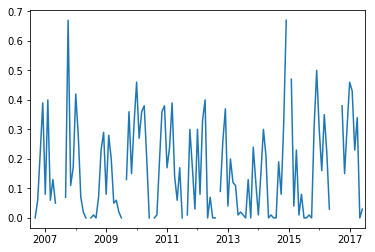

In [92]:
sfo_weather.resample('M').max().PrecipitationIn.plot()

## We can aggregate over various times and calculate statistics

In [93]:
g = sfo_weather.groupby(sfo_weather.index.year)

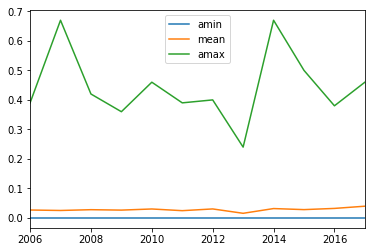

In [94]:
g.aggregate([np.min, np.mean, np.max])['PrecipitationIn'].plot()

In [95]:
sfo_weather.columns

Index(['Conditions', 'DateUTC', 'Dew PointF', 'Events', 'Gust SpeedMPH',
       'Humidity', 'PrecipitationIn', 'Sea Level PressureIn', 'TemperatureF',
       'TimePDT', 'TimePST', 'VisibilityMPH', 'Wind Direction',
       'Wind SpeedMPH', 'WindDirDegrees'],
      dtype='object')

In [96]:
sfo_weather['Wind Direction'].unique()

array(['WNW', 'Calm', 'NNW', 'NNE', 'North', 'NW', 'South', 'West', 'SSW',
       'Variable', 'WSW', 'SW', 'NE', 'SSE', 'SE', 'East', 'ENE', 'ESE'], dtype=object)

## let's convert these to degrees and radians and make a rose plot

Conversions:
http://blog.weatherflow.com/degrees-of-wind-direction-along-south-carolina-onshore-vs-offshore/

In [97]:
dir_str = ['WNW', 'Calm', 'NNW', 'NNE', 'North', 'NW', 'South', 'West', 'SSW',
       'Variable', 'WSW', 'SW', 'NE', 'SSE', 'SE', 'East', 'ENE', 'ESE']
dir_deg = np.array([52, 0, 60, 20, 64, 56, 32, 48, 36,
               0, 44, 40, 8, 28, 24, 16, 12, 20])*360/64

In [98]:
wind_lookup = dict(zip(dir_str,dir_deg))

In [99]:
sfo_weather['wind_deg'] = [wind_lookup[i] for i in sfo_weather['Wind Direction']]

### Convert to Radians

In [100]:
sfo_weather['wind_rad'] = sfo_weather.wind_deg* np.pi/180

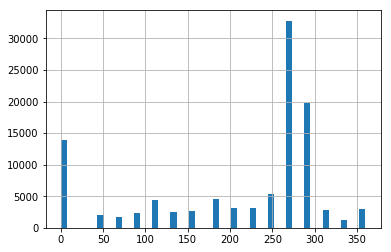

In [101]:
sfo_weather['wind_deg'].hist(bins=50)

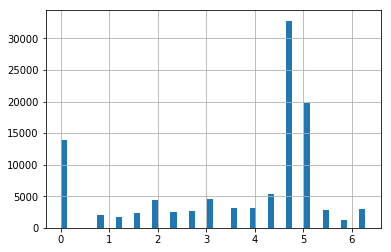

In [102]:
sfo_weather['wind_rad'].hist(bins=50)

In [103]:
counts, bins = np.histogram(sfo_weather['wind_rad'], bins=50)

In [104]:
counts

array([13982,     0,     0,     0,     0,     0,  1971,     0,     0,
        1783,     0,     0,  2301,     0,     0,  4358,     0,     0,
        2574,     0,     0,  2618,     0,     0,  4586,     0,     0,
           0,  3095,     0,     0,  3172,     0,     0,  5327,     0,
           0, 32807,     0,     0, 19732,     0,     0,  2855,     0,
           0,  1275,     0,     0,  2936])

In [105]:
bins

array([ 0.        ,  0.12566371,  0.25132741,  0.37699112,  0.50265482,
        0.62831853,  0.75398224,  0.87964594,  1.00530965,  1.13097336,
        1.25663706,  1.38230077,  1.50796447,  1.63362818,  1.75929189,
        1.88495559,  2.0106193 ,  2.136283  ,  2.26194671,  2.38761042,
        2.51327412,  2.63893783,  2.76460154,  2.89026524,  3.01592895,
        3.14159265,  3.26725636,  3.39292007,  3.51858377,  3.64424748,
        3.76991118,  3.89557489,  4.0212386 ,  4.1469023 ,  4.27256601,
        4.39822972,  4.52389342,  4.64955713,  4.77522083,  4.90088454,
        5.02654825,  5.15221195,  5.27787566,  5.40353936,  5.52920307,
        5.65486678,  5.78053048,  5.90619419,  6.03185789,  6.1575216 ,
        6.28318531])

In [106]:
bins=(bins[1:]+bins[:-1])/2

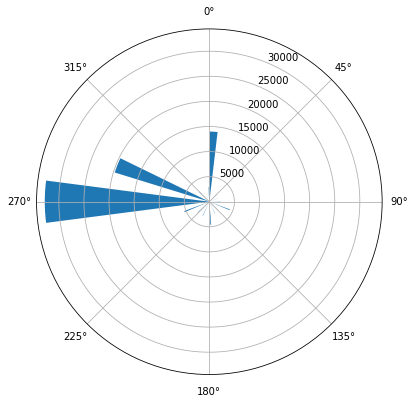

In [107]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
widths = np.pi/4e5*counts
bars = ax.bar(bins,counts, width=widths)


## Cool -- is it seasonal?

In [108]:
# let's grab the calendar module to convert month numbers to names
import calendar

In [109]:
with PdfPages('monthly_wind_dir.pdf') as outpdf:
    for cn, cg in sfo_weather.groupby(sfo_weather.index.month):
        print('plotting for {0}'.format(calendar.month_name[cn]))
        counts, bins = np.histogram(cg['wind_rad'], bins=50)
        bins = (bins[1:]+bins[:-1])/2
        fig = plt.figure()
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        widths = np.pi/4e4*counts
        bars = ax.bar(bins,counts, width=widths)
        plt.title(calendar.month_name[cn])
        outpdf.savefig()
        plt.close()

plotting for January
plotting for February
plotting for March
plotting for April
plotting for May
plotting for June
plotting for July
plotting for August
plotting for September
plotting for October
plotting for November
plotting for December


## Look at wind speed --- needs some cleaning

In [110]:
sfo_weather['Wind SpeedMPH'].unique()

array(['3.5', '5.8', '4.6', '6.9', 'Calm', '10.4', '12.7', '13.8', '16.1',
       '11.5', '8.1', '9.2', '20.7', '17.3', '15.0', '18.4', '25.3',
       '21.9', '19.6', '31.1', '34.5', '36.8', '23.0', '24.2', '28.8',
       '26.5', nan, '29.9', '32.2', '27.6', '35.7', '38.0', '39.1', '33.4',
       '40.3', '41.4', '48.3', '43.7', '52.9', '44.9', '46.0', '42.6',
       '241.7', '242.8', '189.9'], dtype=object)

In [111]:
sfo_weather.dtypes

Conditions               object
DateUTC                  object
Dew PointF              float64
Events                   object
Gust SpeedMPH            object
Humidity                float64
PrecipitationIn         float64
Sea Level PressureIn    float64
TemperatureF            float64
TimePDT                  object
TimePST                  object
VisibilityMPH           float64
Wind Direction           object
Wind SpeedMPH            object
WindDirDegrees            int64
wind_deg                float64
wind_rad                float64
dtype: object

In [112]:
sfo_weather['Wind SpeedMPH'] = [0 if i == 'Calm' else float(i) for i in sfo_weather['Wind SpeedMPH']]

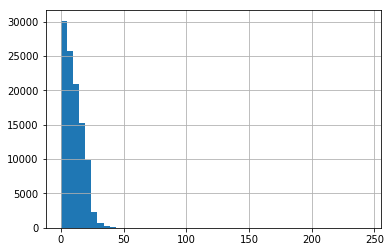

In [113]:
sfo_weather['Wind SpeedMPH'].hist(bins=50)

In [114]:
len(sfo_weather.loc[sfo_weather['Wind SpeedMPH']>50])

4

In [115]:
sfo_weather['Wind SpeedMPH'] = [0 if i == 'Calm' else np.nan if float(i) > 55 else float(i) for i in sfo_weather['Wind SpeedMPH']]

In [116]:
sfo_weather['Wind SpeedMPH'].describe()

count    105335.000000
mean         10.153103
std           7.175511
min           0.000000
25%           4.600000
50%           9.200000
75%          15.000000
max          52.900000
Name: Wind SpeedMPH, dtype: float64

## Is there fog at SFO?

In [117]:
sfo_weather.VisibilityMPH.unique()

array([ 10. ,   9. ,   8. ,   7. ,   6. ,   1. ,   0.5,   1.5,   4. ,
         3. ,   5. ,   0.2,   2.5,   2. ,   1.2,   0.1,   0.8,   1.8,
         nan,  95. ,  64. ])

In [118]:
sfo_weather.VisibilityMPH[sfo_weather.VisibilityMPH>50].count()

2

In [119]:
sfo_weather.loc[sfo_weather.VisibilityMPH>50,'VisibilityMPH'] = np.nan

In [120]:
sfo_weather.VisibilityMPH[sfo_weather.VisibilityMPH>50].count()

0

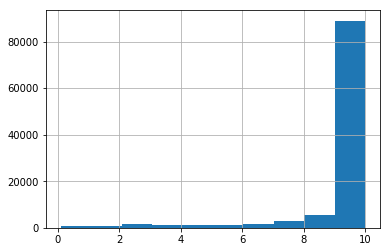

In [121]:
sfo_weather.VisibilityMPH.hist()

In [ ]:
for cn, cg in sfo_weather.groupby(sfo_weather.index.month):
    plt.figure()
    cg.VisibilityMPH.hist()
    plt.title(calendar.month_name[cn])
    

## Let's look at Gusts. More data cleaning!

In [123]:
sfo_weather['Gust SpeedMPH'].unique()

array(['-', '16.1', '18.4', '20.7', '29.9', '27.6', '23.0', '21.9', '26.5',
       '24.2', '28.8', '39.1', '42.6', '47.2', '33.4', '32.2', '25.3',
       '19.6', '17.3', '31.1', '38.0', '34.5', '35.7', '36.8', '41.4',
       '40.3', '43.7', '44.9', '51.8', '50.6', '57.5', '48.3', '55.2',
       '46.0', '49.5', '65.6', '59.8', '66.7', '61.0', '54.1', '58.7',
       '52.9', '56.4'], dtype=object)

In [124]:
sfo_weather.loc[sfo_weather['Gust SpeedMPH']=='-','Gust SpeedMPH'] = np.nan
sfo_weather['Gust SpeedMPH'] = sfo_weather['Gust SpeedMPH'].astype(float)

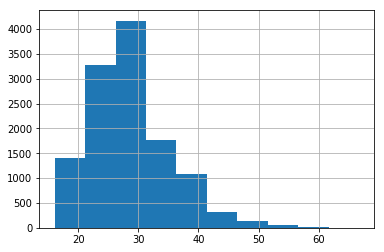

In [125]:
sfo_weather['Gust SpeedMPH'].hist()

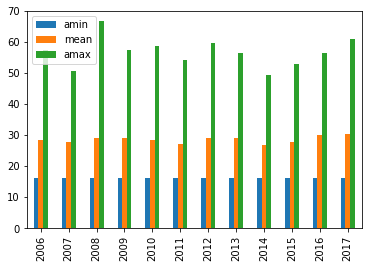

In [126]:
sfo_weather['Gust SpeedMPH'].groupby(sfo_weather.index.year).aggregate([np.min, np.mean, np.max]).plot(kind='bar')

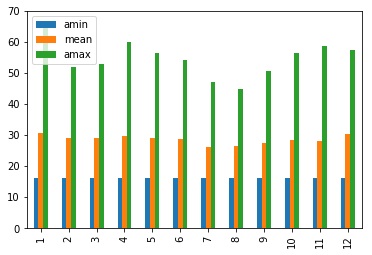

In [127]:
sfo_weather['Gust SpeedMPH'].groupby(sfo_weather.index.month).aggregate([np.min, np.mean, np.max]).plot(kind='bar')

## Which is the most variable month for gusts

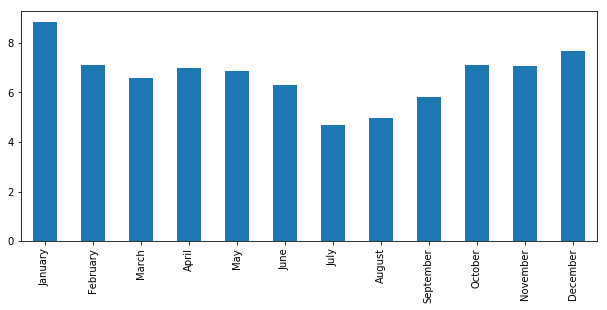

In [128]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
sfo_weather['Gust SpeedMPH'].groupby(sfo_weather.index.month).aggregate(np.std).plot(kind='bar')
ax.set_xticklabels([calendar.month_name[i] for i in list(range(1,13))]);

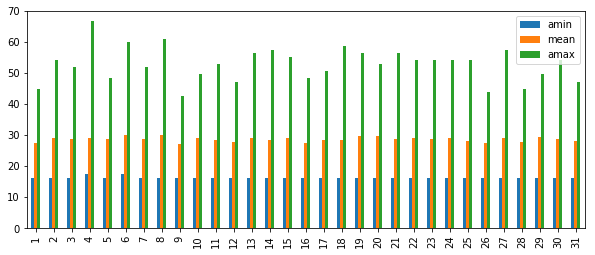

In [129]:
sfo_weather['Gust SpeedMPH'].groupby(sfo_weather.index.day).aggregate(
    [np.min, np.mean, np.max]).plot(kind='bar', figsize=(10,4))